In [67]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pdfplumber
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
#%%


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## load ChatQA-1.5 tokenizer and model
model_id = "C:/Users/jywun/Desktop/NYCU/模組/QA_ARAG/Llama3-ChatQA-1.5-8B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16,output_attentions=True).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


In [40]:
input_text = "Hello, can you do me a favor?"
inputs = tokenizer(input_text, return_tensors="pt").to(device)


{'input_ids': tensor([[9906,   11,  649,  499,  656,  757,  264, 4799,   30]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [41]:
outputs = model(**inputs)
print(outputs.keys())

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


odict_keys(['logits', 'past_key_values', 'attentions'])


In [50]:
attentions = outputs.attentions
for i, layer_att in enumerate(attentions):
    print(f"Layer {i+1}:")
    print(f"Attention weights shape: {layer_att.shape}")
    print()

Layer 1:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 2:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 3:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 4:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 5:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 6:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 7:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 8:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 9:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 10:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 11:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 12:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 13:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 14:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 15:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 16:
Attention weights shape: torch.Size([1, 32, 9, 9])

Layer 17:
Attenti

In [57]:
attention_layer_1 = attentions[0]
attention_head_1 = attention_layer_1[0, 0, :, :]
attention_head_1

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6470, 0.3530, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5928, 0.3674, 0.0396, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5322, 0.3359, 0.0815, 0.0506, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2830, 0.3823, 0.2159, 0.1017, 0.0172, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1655, 0.1549, 0.1427, 0.4180, 0.0778, 0.0411, 0.0000, 0.0000, 0.0000],
        [0.1458, 0.1085, 0.1503, 0.2219, 0.2377, 0.0953, 0.0405, 0.0000, 0.0000],
        [0.0953, 0.0699, 0.0844, 0.1290, 0.2443, 0.2074, 0.1282, 0.0414, 0.0000],
        [0.1171, 0.0720, 0.0883, 0.1246, 0.1037, 0.1531, 0.1005, 0.0640, 0.1768]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SliceBackward0>)

In [64]:
input_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
attention_matrix = attention_head_1.detach().cpu().numpy()
attention_matrix

array([[1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     ],
       [0.647  , 0.353  , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     ],
       [0.593  , 0.3674 , 0.0396 , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     ],
       [0.532  , 0.336  , 0.08154, 0.0506 , 0.     , 0.     , 0.     ,
        0.     , 0.     ],
       [0.283  , 0.3823 , 0.216  , 0.1017 , 0.01717, 0.     , 0.     ,
        0.     , 0.     ],
       [0.1655 , 0.1549 , 0.1427 , 0.418  , 0.07776, 0.04114, 0.     ,
        0.     , 0.     ],
       [0.1458 , 0.10846, 0.1503 , 0.2219 , 0.2377 , 0.09534, 0.04053,
        0.     , 0.     ],
       [0.09534, 0.06995, 0.0844 , 0.129  , 0.2443 , 0.2074 , 0.1282 ,
        0.04138, 0.     ],
       [0.1171 , 0.07196, 0.0883 , 0.1246 , 0.1037 , 0.1531 , 0.10046,
        0.06396, 0.1768 ]], dtype=float16)

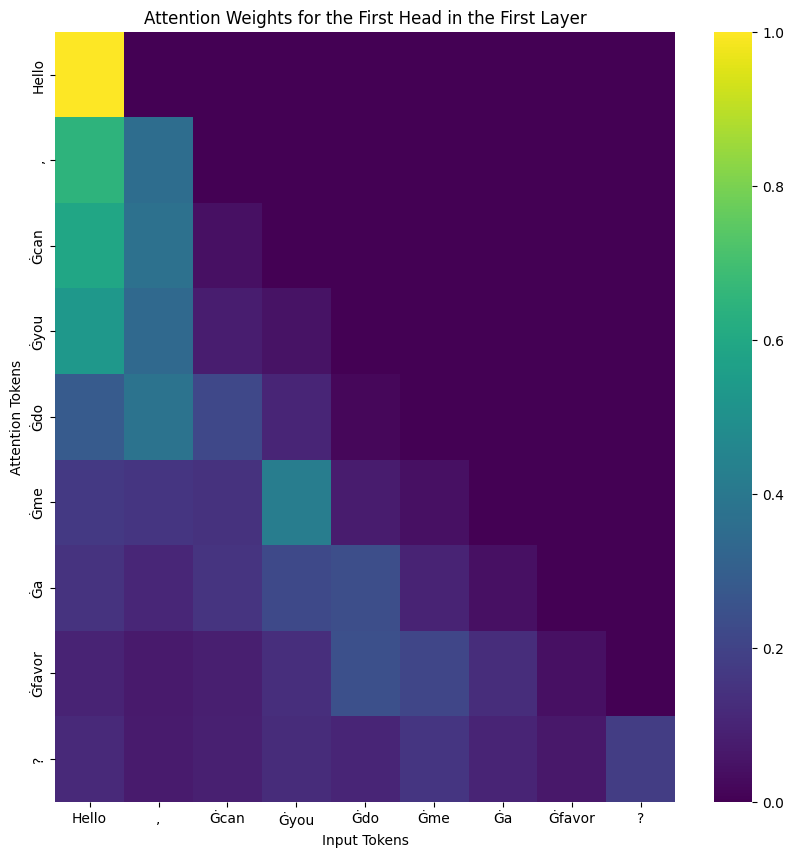

In [68]:
plt.figure(figsize=(10, 10))
sns.heatmap(attention_matrix, xticklabels=input_tokens, yticklabels=input_tokens, cmap='viridis')
plt.xlabel("Input Tokens")
plt.ylabel("Attention Tokens")
plt.title("Attention Weights for the First Head in the First Layer")
plt.show()

In [43]:
outputs.logits.shape

torch.Size([1, 9, 128256])

In [44]:
past_key_values = outputs.past_key_values

# 显示 past_key_values 中每个张量的形状
for i, layer_past in enumerate(past_key_values):
    print(f"Layer {i+1}:")
    print(f"Key shape: {layer_past[0].shape}")
    print(f"Value shape: {layer_past[1].shape}")
    print()

Layer 1:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 2:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 3:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 4:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 5:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 6:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 7:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 8:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 9:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 10:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 11:
Key shape: torch.Size([1, 8, 9, 128])
Value shape: torch.Size([1, 8, 9, 128])

Layer 12:
Key shape: torch.Siz

In [ ]:
# from transformers import GPT2Tokenizer, GPT2LMHeadModel
# import torch
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 加载GPT-2模型和tokenizer
# model_name = 'gpt2'
# tokenizer = GPT2Tokenizer.from_pretrained(model_name)
# model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)

# # 初始输入文本
# input_text = "Once upon a time"
# inputs = tokenizer(input_text, return_tensors="pt")

# # 设置模型为评估模式
# model.eval()

# # 初始化生成的token列表
# generated_tokens = inputs['input_ids']

# # 定义要生成的token数量
# num_tokens_to_generate = 10

# # 存储每个生成步骤的注意力权重
# all_attentions = []

# # 自回归生成
# with torch.no_grad():
#     for _ in range(num_tokens_to_generate):
#         # 获取模型输出
#         outputs = model(generated_tokens)

#         # 提取logits和注意力权重
#         logits = outputs.logits
#         attentions = outputs.attentions

#         # 记录当前步骤的注意力权重
#         all_attentions.append(attentions)

#         # 获取当前生成的下一个token
#         next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)

#         # 将生成的token添加到输入序列中
#         generated_tokens = torch.cat((generated_tokens, next_token), dim=1)

# # 准备可视化数据
# def plot_attention(attention, input_tokens, output_tokens, layer=0, head=0):
#     attention = attention[layer][0, head].detach().cpu().numpy()
    
#     plt.figure(figsize=(10, 10))
#     sns.heatmap(attention, xticklabels=input_tokens, yticklabels=output_tokens, cmap='viridis')
#     plt.xlabel("Input Tokens")
#     plt.ylabel("Output Tokens")
#     plt.title(f"Attention Weights for Layer {layer + 1}, Head {head + 1}")
#     plt.show()

# # 初始输入token列表
# input_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# # 生成的token列表
# generated_tokens_list = generated_tokens[0].tolist()
# output_tokens = tokenizer.convert_ids_to_tokens(generated_tokens_list)

# # 可视化生成的第一个token时的注意力权重（从第1层第1个头）
# plot_attention(all_attentions[0], input_tokens, output_tokens[:len(input_tokens) + 1], layer=0, head=0)
